# Scan aerosols and look at color dependence
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date November 22 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import os
import re 

In [4]:
import pysynphot as S

In [5]:
import astropy.units as u

In [6]:
from scipy.interpolate import interp1d

In [7]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [8]:
import sys
sys.path.append('../libradtransim')
sys.path.append('../LSSTFiltersKG')
sys.path.append('../lsstphotometry')

In [9]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst
import libLSSTPhotometry as photo

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


In [10]:
#help(atm)

In [11]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Defining LSST telescope

In [12]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [13]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [14]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [15]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [16]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [17]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


## LSST effective filter


### Get the bands à la pysynphot

In [18]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('..')

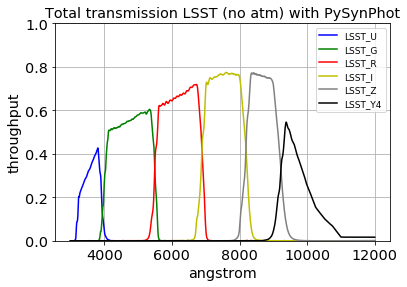

In [19]:
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

## Fills all bands of LSST

### Create a LSSTTransmission object

In [20]:
lsstdetector=photo.LSSTTransmission('lssttel')

### Initialize the LSST transmission object with the bands read above

In [21]:
lsstdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4])

## Read atmosphere

In [22]:
tau_aerosol=np.linspace(0.,0.5,10)
lambda0_aerosol=500. # nm
airmass=1.
pwv=4.0     # mm
ozone=300. # DU

In [23]:
photo_atm=photo.Atmosphere('libradtran')

In [24]:
index=0
for tau in tau_aerosol:
      path,thefile=atm.ProcessSimulationaer(airmass,pwv,ozone,lambda0_aerosol,tau) 
      fullfilename=os.path.join(path,thefile)
      atm_data=np.loadtxt(fullfilename)
      wl_atm=atm_data[:,0]
      tr_atm=atm_data[:,1]  
      if index==0:
        photo_atm.fill_array(wl_atm)        
      photo_atm.fill_array(tr_atm)        
      index+=1

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0555555555556
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer5.INP')
('Output to file         

### Check the output of simulation

In [25]:
theatmosph=photo_atm.get_array()

In [26]:
pd.DataFrame(theatmosph)

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,...,1191.000000,1192.000000,1193.000000,1194.000000,1195.000000,1196.000000,1197.000000,1198.000000,1199.000000,1200.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963772,0.985182,0.985182,0.970041,0.970041,0.977899,0.977899,0.963689,0.963689,0.960683
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948341,0.969432,0.969432,0.954581,0.954581,0.962343,0.962343,0.948413,0.948413,0.945492
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.933157,0.953933,0.953933,0.939367,0.939367,0.947035,0.947035,0.933379,0.933379,0.930541
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.918216,0.938682,0.938682,0.924395,0.924395,0.931970,0.931970,0.918583,0.918583,0.915826
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.903514,0.923675,0.923675,0.909663,0.909663,0.917145,0.917145,0.904022,0.904022,0.901345
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.889048,0.908908,0.908908,0.895165,0.895165,0.902556,0.902556,0.889691,0.889691,0.887092
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.874813,0.894377,0.894377,0.880898,0.880898,0.888199,0.888199,0.875588,0.875588,0.873064
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860807,0.880078,0.880078,0.866858,0.866858,0.874070,0.874070,0.861709,0.861709,0.859259
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.847024,0.866008,0.866008,0.853043,0.853043,0.860166,0.860166,0.848049,0.848049,0.845671


## Do multiplication

### Get all pysynphot passband for the atmosphere

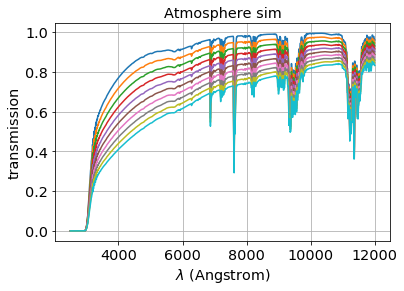

In [27]:
photo_atm.plot_pys_bp()

### Initialise the lsstdetector with the atmosphere results

In [28]:
all_bp_atm=photo_atm.get_pys_pb()

In [29]:
lsstdetector.fill_atm_allevents(all_bp_atm)

### Multiplication of atmosphere transmission by filters transmission

In [30]:
all_transmissions=lsstdetector.make_transmissions()

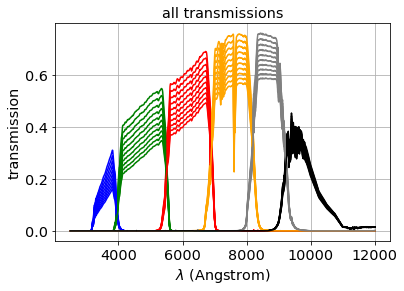

In [31]:
lsstdetector.plot_transmissions()

# Observation

## Defines the SED

In [32]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)
sed.flux

array([  2.16790002e-14,   2.66180002e-14,   2.03460007e-14, ...,
         9.32662788e-19,   9.23448099e-19,   9.14324504e-19])

Text(0.5,1,u'hd111980_stis_003.fits')

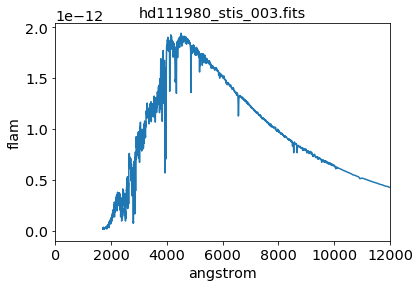

In [33]:
plt.plot(sed.wave,sed.flux)
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
plt.title(os.path.basename(sed.name))

- flam unit is erg per sec per cm2 per angstrom

## Defines all the  observation

In [34]:
rt_observations=photo.LSSTObservation('libradtran_aerosols')

In [35]:
rt_observations.fill_sed([sed])
rt_observations.fill_transmission(all_transmissions)

In [36]:
all_obs=rt_observations.make_observations()

((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does

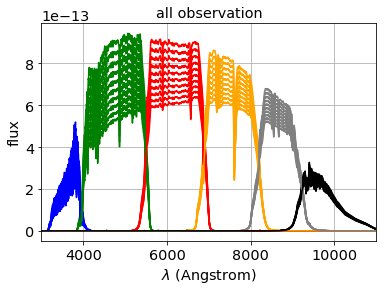

In [37]:
rt_observations.plot_observations(0)

### Magnitude

In [42]:
obssamplarray=rt_observations.make_samplobservations()

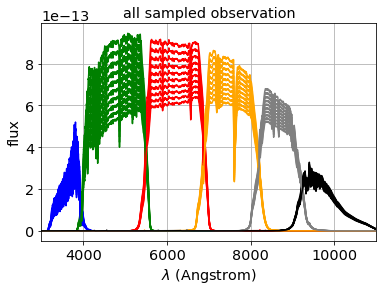

In [43]:
rt_observations.plot_samplobservations(0)